In [1]:
import numpy as np
import pandas as pd
import scipy.io
import pyriemann as pr
import networkx as nx
import os

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
%run Pipeline_for_SPD.ipynb

Populating the interactive namespace from numpy and matplotlib


In [2]:

labels = pd.read_csv("data/targets 28.02.2018.csv", sep=";").reset_index(drop=True)
# labels = labels[labels["patient_number"].isin(mri_data["index_r"])]

idx_to_label = ["C", "D", "E", "DE", "NE", "ND", "TLE", "NoTLE"]
label_to_idx = {l : i for i, l in enumerate(idx_to_label)}

for col in labels.columns[1:]:
    labels[col] = labels[col].apply(lambda x: label_to_idx[x] if x in label_to_idx else np.nan)
    
DE_idx = labels["target"].notnull()
E_idx = labels["E/no E"].notnull()
D_idx = labels["D/no D"].notnull()
E_C_idx = labels["E/C"].notnull()
D_C_idx = labels["D/C"].notnull()
TLE_noE_idx = labels["TLE/no E"].notnull()
TLE_C_idx = labels["TLE/C"].notnull()
DE_E_idx = labels["DE/E"].notnull()

DE_D_idx = E_C_idx == False

In [3]:
labels.head()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C,TLENegative/C,NoTLE/C
0,P001,2,2,5,2.0,6.0,6.0,NaN,2.0,NaN,NaN,NaN,NaN
1,P002,3,2,1,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,7.0
2,P003,2,2,5,2.0,6.0,6.0,NaN,2.0,NaN,NaN,NaN,NaN
3,P004,1,4,1,NaN,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,P006,2,2,5,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,7.0


In [4]:
patients = labels['patient_number']

In [5]:
data = []
for l in patients:
    X_new = pd.read_csv('./data/clean_last/{}.csv'.format(l), index_col=0)
    data.append(np.array(X_new))

1. Epilepsy / no epilepsy
2. Depression / no depression
3. Epilepsy / control
4. Depression / control
5. TLE / no epilepsy
6. TLE / control
7. Epilepsy with depression / only epilepsy
8. Epilepsy with depression / only depression

## Threshold = 0.3

In [6]:
tr = 0.3
scoring = 'roc_auc'

### Epilepsy  / No Epilepsy

Target distribution: 
4    50
2    50
Name: E/no E, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 50 folds for each of 27 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 72.5min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 78.5min finished


(training took 4709.430715799332s)

Training MDM...
Fitting 50 folds for each of 3 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished


(training took 152.92335391044617s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 0.0001, clf__gamma = 1, clf__kernel =...",0.5000,0.000000
LR,"clf__C = 0.0001, metric = riemann",0.5552,0.164854
KNN,"metric = riemann, n_neighbors = 5",0.5840,0.176182
MDM,metric = riemann,0.5464,0.175200


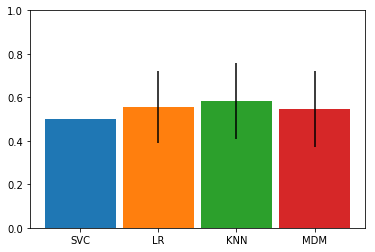

Best model: 
KNN
metric = riemann
n_neighbors = 5
mean = 0.40320000000000006
std = 0.18844033538497007


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

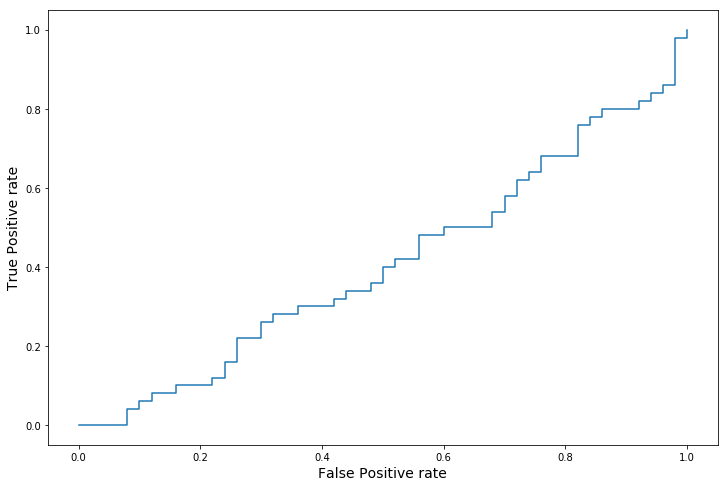

auc = 0.4084


,False Positive rate (fixed),False Negative rate
0,0.10,0.94
1,0.15,0.92
2,0.20,0.90
3,0.30,0.74


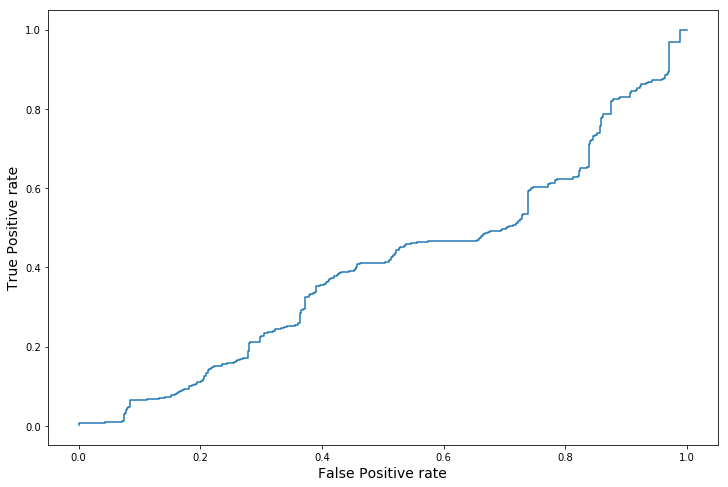

auc = 0.40615999999999997


,False Positive rate (fixed),False Negative rate
0,0.10,0.934
1,0.15,0.926
2,0.20,0.890
3,0.30,0.774


In [7]:
# n_splits = 2
n_splits = 10
y = labels["E/no E"]
pos_label = label_to_idx["E"]
pipe = SPD_pipeline(tr, 0.1)

### Pipeline training
best_model_E, grid_cv_svc_E, grid_cv_lr_E, grid_cv_mdm_E, grid_cv_knn_E = pipe.train_grid_cv(
    data, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')

### Validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data)
scores_E = cross_val_score(best_model_E, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs=-1)
  
print("mean =", scores_E.mean())
print("std =", scores_E.std())

### Save model and predictions
pipe.save_model(best_model_E, "models/fmri_rim_E.pkl")
probas_E = pipe.repeated_cross_val_predict_proba(best_model_E, data, y, cv=cv, pos_label=pos_label, file = 'models/rim_E_prediction.csv')

### ROC-AUC
# average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_E, pos_label, E_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_E, pos_label, E_idx)
pipe.get_fpr_fnr(fpr, tpr)

## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### Depression  / No depression

Target distribution: 
5    50
1    50
Name: D/no D, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 50 folds for each of 27 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 42.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 66.2min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 71.9min finished


(training took 4314.300523042679s)

Training MDM...
Fitting 50 folds for each of 3 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.2min finished


(training took 135.42394590377808s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 0.0001, clf__gamma = 0.0001, clf__ker...",0.6432,0.170052
LR,"clf__C = 1, metric = euclid",0.4184,0.185939
KNN,"metric = riemann, n_neighbors = 5",0.5024,0.186618
MDM,metric = riemann,0.3544,0.170835


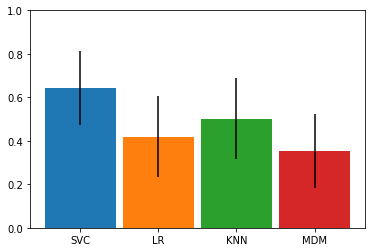

Best model: 
SVC
clf__C = 0.0001
clf__gamma = 0.0001
clf__kernel = rbf
metric = riemann
mean = 0.6084
std = 0.17493267276298044


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

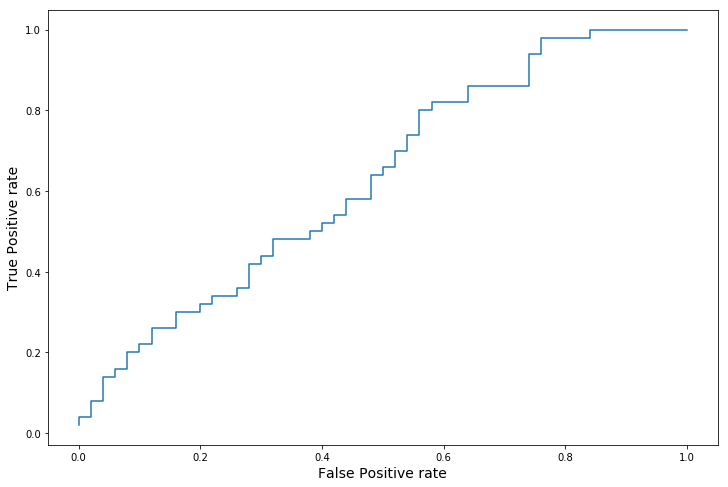

auc = 0.63


,False Positive rate (fixed),False Negative rate
0,0.10,0.78
1,0.15,0.74
2,0.20,0.68
3,0.30,0.56


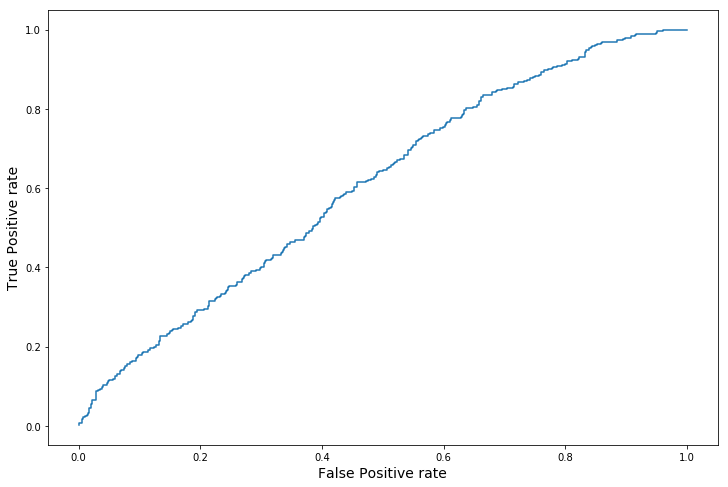

auc = 0.607532


,False Positive rate (fixed),False Negative rate
0,0.10,0.820
1,0.15,0.760
2,0.20,0.708
3,0.30,0.598


In [ ]:
n_splits = 10
y = labels["D/no D"]
pos_label = label_to_idx["D"]
pipe = SPD_pipeline(tr, 0.1)

# Pipeline training
best_model_D, grid_cv_svc_D, grid_cv_lr_D, grid_cv_mdm_D, grid_cv_knn_D = pipe.train_grid_cv(
    data, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data)
scores_D = cross_val_score(best_model_D, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
  
print("mean =", scores_D.mean())
print("std =", scores_D.std())


pipe.save_model(best_model_D, "models/fmri_rim_D.pkl")
probas_D = pipe.repeated_cross_val_predict_proba(best_model_D, data, y, cv=cv, pos_label=pos_label, file = 'models/rim_D_prediction.csv')

# average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_D, pos_label, D_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_D, pos_label, D_idx)
pipe.get_fpr_fnr(fpr, tpr)

## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### Epilepsy / Control

Target distribution: 
0.0    25
2.0    25
Name: E/C, dtype: int64 

loading fitted SVC...

loading fitted LR...

loading fitted KNN...

loading fitted MDM...

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 1, clf__gamma = 0.0001, clf__kernel =...",0.5440,0.098306
LR,"clf__C = 0.01, metric = euclid",0.5936,0.169585
KNN,"metric = riemann, n_neighbors = 5",0.5040,0.250184
MDM,metric = riemann,0.4896,0.115533


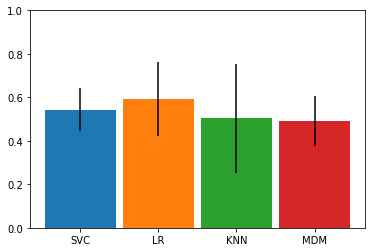

Best model: 
LR
clf__C = 0.01
metric = euclid
mean = 0.5912
std = 0.16145141684110426


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

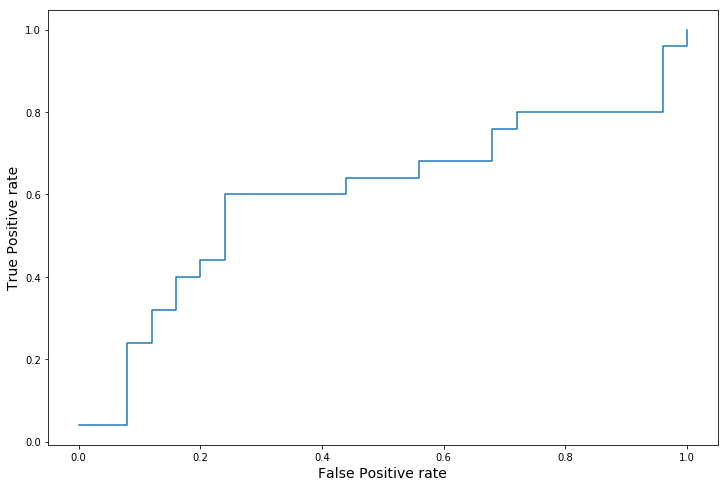

auc = 0.5983999999999999


,False Positive rate (fixed),False Negative rate
0,0.10,0.76
1,0.15,0.68
2,0.20,0.56
3,0.30,0.40


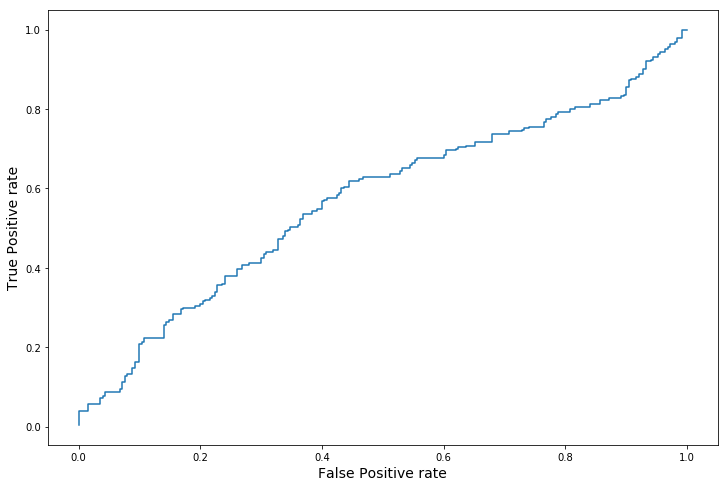

auc = 0.569808


,False Positive rate (fixed),False Negative rate
0,0.10,0.792
1,0.15,0.732
2,0.20,0.692
3,0.30,0.576


In [7]:
n_splits = 5

y = labels[E_C_idx]["E/C"]
data_EC = [data[i] for i in np.where(E_C_idx == True)[0]]
pos_label = label_to_idx["E"]
pipe = SPD_pipeline(tr, 0.1)


best_model_EC, grid_cv_svc_EC, grid_cv_lr_EC, grid_cv_mdm_EC, grid_cv_knn_EC = pipe.train_grid_cv(
    data_EC, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_EC)
scores_EC = cross_val_score(best_model_EC, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_EC.mean())
print("std =", scores_EC.std())


pipe.save_model(best_model_EC, "models/fmri_rim_EC.pkl")
probas_EC = pipe.repeated_cross_val_predict_proba(best_model_EC, data_EC, y, cv=cv, pos_label=pos_label, file = 'models/rim_EC_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_EC, pos_label, E_C_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_EC, pos_label, E_C_idx)
pipe.get_fpr_fnr(fpr, tpr)

## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### Depression / Control

Target distribution: 
0.0    25
1.0    25
Name: D/C, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 25 folds for each of 12 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.0min finished


(training took 240.001953125s)

Training MDM...
Fitting 25 folds for each of 3 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   35.3s finished


(training took 36.44649600982666s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 1, clf__gamma = 0.0001, clf__kernel =...",0.5952,0.242010
LR,"clf__C = 1, metric = riemann",0.6736,0.227313
KNN,"metric = riemann, n_neighbors = 5",0.5248,0.173185
MDM,metric = riemann,0.6192,0.216479


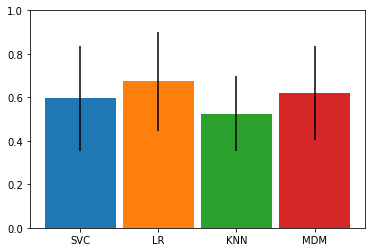

Best model: 
LR
clf__C = 1
metric = riemann
mean = 0.6936
std = 0.20358546117048731


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

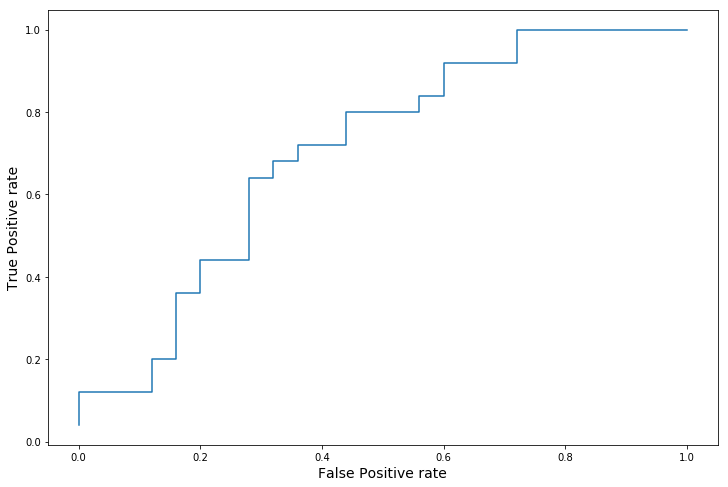

auc = 0.7023999999999999


,False Positive rate (fixed),False Negative rate
0,0.10,0.88
1,0.15,0.80
2,0.20,0.56
3,0.30,0.36


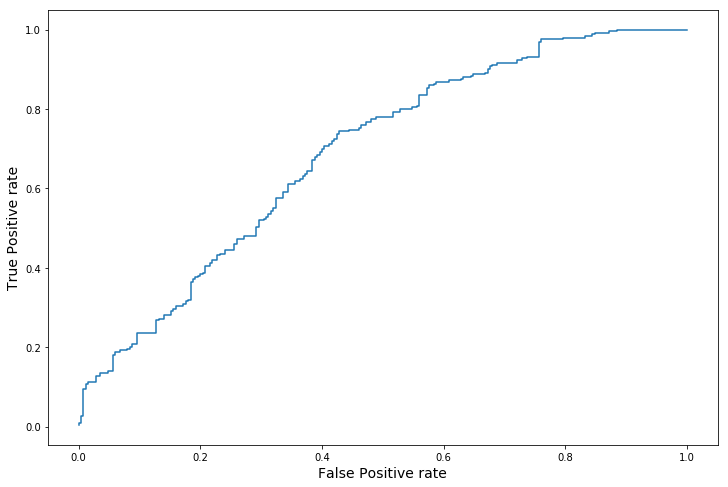

auc = 0.6879679999999999


,False Positive rate (fixed),False Negative rate
0,0.10,0.764
1,0.15,0.720
2,0.20,0.616
3,0.30,0.480


In [7]:
# 0.57
n_splits = 5

y = labels[D_C_idx]["D/C"]
data_DC = [data[i] for i in np.where(D_C_idx == True)[0]]
pos_label = label_to_idx["D"]
pipe = SPD_pipeline(tr, 0.1)


best_model_DC, grid_cv_svc_DC, grid_cv_lr_DC, grid_cv_mdm_DC, grid_cv_knn_DC = pipe.train_grid_cv(
    data_DC, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_DC)
scores_DC = cross_val_score(best_model_DC, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_DC.mean())
print("std =", scores_DC.std())


pipe.save_model(best_model_DC, "models/fmri_rim_DC.pkl")
probas_DC = pipe.repeated_cross_val_predict_proba(best_model_DC, data_DC, y, cv=cv, pos_label=pos_label, file = 'models/rim_DC_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DC, pos_label, D_C_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DC, pos_label, D_C_idx)
pipe.get_fpr_fnr(fpr, tpr)
                           
## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### TLE / no Epilepsy

Target distribution: 
4.0    50
6.0    30
Name: TLE/no E, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 25 folds for each of 15 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.8min


(training took 685.6053841114044s)

Training MDM...
Fitting 25 folds for each of 3 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 11.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   52.0s finished


(training took 53.6678409576416s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 0.0001, clf__gamma = 0.0001, clf__ker...",0.516667,0.142829
LR,"clf__C = 0.0001, metric = euclid",0.617333,0.165024
KNN,"metric = riemann, n_neighbors = 5",0.516667,0.161795
MDM,metric = riemann,0.563333,0.134907


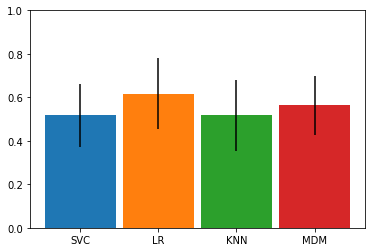

Best model: 
LR
clf__C = 0.0001
metric = euclid
mean = 0.6153333333333334
std = 0.15433873280691549


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

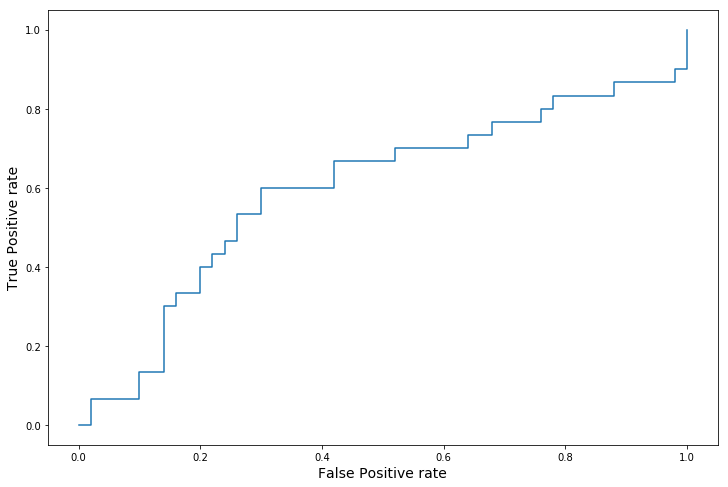

auc = 0.5946666666666666


,False Positive rate (fixed),False Negative rate
0,0.10,0.866667
1,0.15,0.700000
2,0.20,0.600000
3,0.30,0.400000


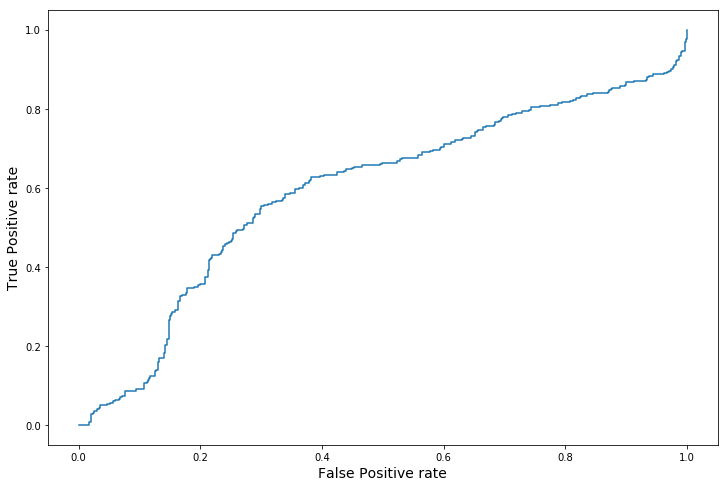

auc = 0.5933266666666667


,False Positive rate (fixed),False Negative rate
0,0.10,0.910000
1,0.15,0.723333
2,0.20,0.643333
3,0.30,0.446667


In [7]:
n_splits = 5

y = labels[TLE_noE_idx]["TLE/no E"]
data_TLE_noE = [data[i] for i in np.where(TLE_noE_idx == True)[0]]
pos_label = label_to_idx["TLE"]
pipe = SPD_pipeline(tr, 0.1)


best_model_TLE_noE, grid_cv_svc_TLE_noE, grid_cv_lr_TLE_noE, grid_cv_mdm_TLE_noE, grid_cv_knn_TLE_noE = pipe.train_grid_cv(
    data_TLE_noE, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_TLE_noE)
scores_TLE_noE = cross_val_score(best_model_TLE_noE, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_TLE_noE.mean())
print("std =", scores_TLE_noE.std())


pipe.save_model(best_model_TLE_noE, "models/fmri_rim_TLE_noE.pkl")
probas_TLE_noE = pipe.repeated_cross_val_predict_proba(best_model_TLE_noE, data_TLE_noE, y, cv=cv, pos_label=pos_label, file = 'models/rim_TLE_noE_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_TLE_noE, pos_label, TLE_noE_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_TLE_noE, pos_label, TLE_noE_idx)
pipe.get_fpr_fnr(fpr, tpr)
                           
## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### TLE / Control

Target distribution: 
6.0    30
0.0    25
Name: TLE/C, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 25 folds for each of 12 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min


(training took 255.26970195770264s)

Training MDM...
Fitting 25 folds for each of 3 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   35.9s finished


(training took 37.00668501853943s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 0.0001, clf__gamma = 1, clf__kernel =...",0.500000,0.000000
LR,"clf__C = 0.01, metric = euclid",0.613333,0.161933
KNN,"metric = riemann, n_neighbors = 5",0.536000,0.165977
MDM,metric = riemann,0.549333,0.181137


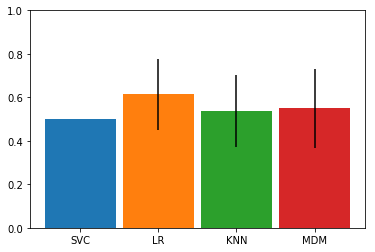

Best model: 
LR
clf__C = 0.01
metric = euclid
mean = 0.6186666666666667
std = 0.15862744613296487


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

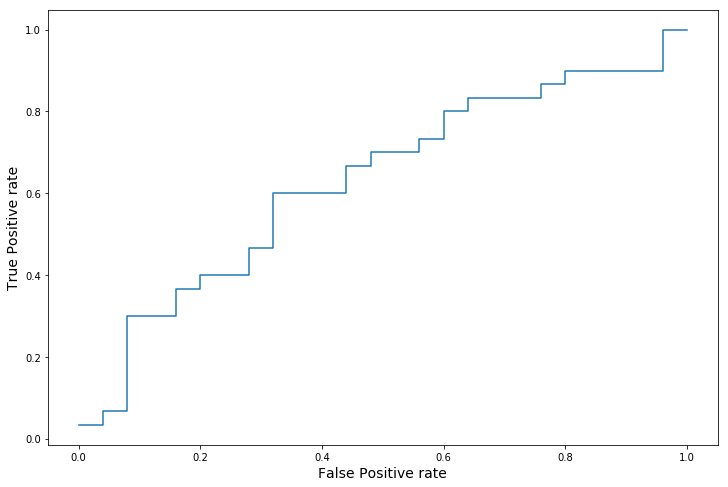

auc = 0.628


,False Positive rate (fixed),False Negative rate
0,0.10,0.700000
1,0.15,0.700000
2,0.20,0.600000
3,0.30,0.533333


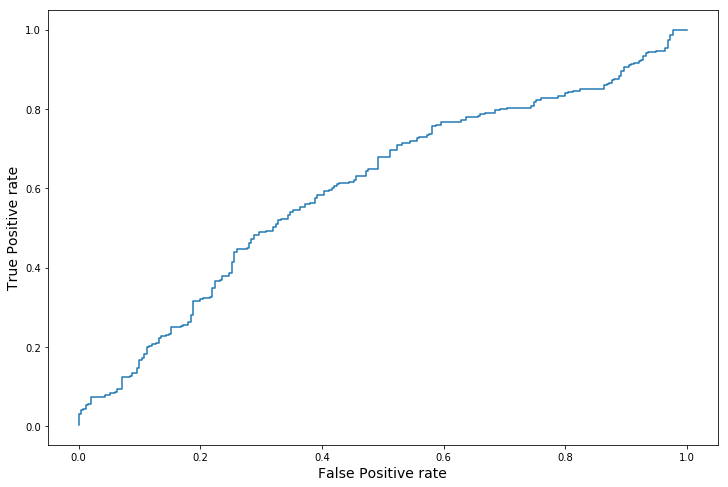

auc = 0.60168


,False Positive rate (fixed),False Negative rate
0,0.10,0.833333
1,0.15,0.766667
2,0.20,0.680000
3,0.30,0.510000


In [7]:
n_splits = 5

y = labels[TLE_C_idx]["TLE/C"]
data_TLE_C = [data[i] for i in np.where(TLE_C_idx == True)[0]]
pos_label = label_to_idx["TLE"]
pipe = SPD_pipeline(tr, 0.1)


best_model_TLE_C, grid_cv_svc_TLE_C, grid_cv_lr_TLE_C, grid_cv_mdm_TLE_C, grid_cv_knn_TLE_C = pipe.train_grid_cv(
    data_TLE_C, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_TLE_C)
scores_TLE_C = cross_val_score(best_model_TLE_C, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_TLE_C.mean())
print("std =", scores_TLE_C.std())


pipe.save_model(best_model_TLE_C, "models/fmri_rim_TLE_C.pkl")
probas_TLE_C = pipe.repeated_cross_val_predict_proba(best_model_TLE_C, data_TLE_C, y, cv=cv, pos_label=pos_label, file = 'models/rim_TLE_C_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_TLE_C, pos_label, TLE_C_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_TLE_C, pos_label, TLE_C_idx)
pipe.get_fpr_fnr(fpr, tpr)
                           
## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### Depression with epilepsy / Epilepsy

Target distribution: 
3.0    25
2.0    25
Name: DE/E, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 25 folds for each of 12 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min


(training took 208.55883193016052s)

Training MDM...
Fitting 25 folds for each of 3 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   32.4s finished


(training took 33.38788890838623s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 1, clf__gamma = 0.01, clf__kernel = r...",0.5920,0.170458
LR,"clf__C = 0.0001, metric = riemann",0.4768,0.114218
KNN,"metric = riemann, n_neighbors = 5",0.4256,0.175956
MDM,metric = riemann,0.4416,0.127238


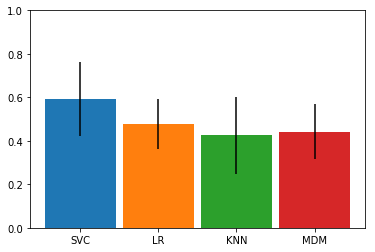

Best model: 
SVC
clf__C = 1
clf__gamma = 0.01
clf__kernel = rbf
metric = riemann
mean = 0.6376000000000001
std = 0.17552845923097485


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

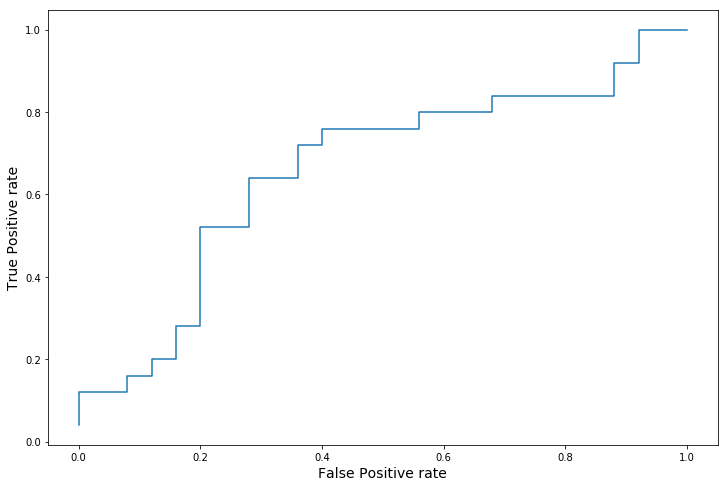

auc = 0.6592


,False Positive rate (fixed),False Negative rate
0,0.10,0.84
1,0.15,0.80
2,0.20,0.48
3,0.30,0.36


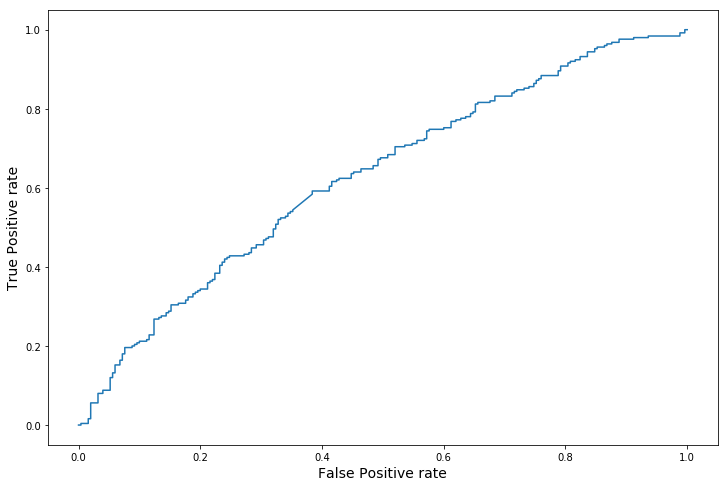

auc = 0.627584


,False Positive rate (fixed),False Negative rate
0,0.10,0.788
1,0.15,0.712
2,0.20,0.656
3,0.30,0.544


In [7]:
n_splits = 5

y = labels[DE_E_idx]["DE/E"]
data_DE_E = [data[i] for i in np.where(DE_E_idx == True)[0]]
pos_label = label_to_idx["DE"]
pipe = SPD_pipeline(tr, 0.1)


best_model_DE_E, grid_cv_svc_DE_E, grid_cv_lr_DE_E, grid_cv_mdm_DE_E, grid_cv_knn_DE_E = pipe.train_grid_cv(
    data_DE_E, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_DE_E)
scores_DE_E = cross_val_score(best_model_DE_E, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_DE_E.mean())
print("std =", scores_DE_E.std())


pipe.save_model(best_model_DE_E, "models/fmri_rim_DE_E.pkl")
probas_DE_E = pipe.repeated_cross_val_predict_proba(best_model_DE_E, data_DE_E, y, cv=cv, pos_label=pos_label, file = 'models/rim_DE_E_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DE_E, pos_label, DE_E_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DE_E, pos_label, DE_E_idx)
pipe.get_fpr_fnr(fpr, tpr)

                      
## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### Depression with epilepsy / Depression

Target distribution: 
3    25
1    25
Name: target, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 25 folds for each of 12 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min


(training took 218.9471378326416s)

Training MDM...
Fitting 25 folds for each of 3 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   32.0s finished


(training took 33.10208988189697s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 100, clf__gamma = 0.01, clf__kernel =...",0.7328,0.172592
LR,"clf__C = 0.01, metric = riemann",0.6976,0.168221
KNN,"metric = riemann, n_neighbors = 5",0.3488,0.150740
MDM,metric = riemann,0.6560,0.177809


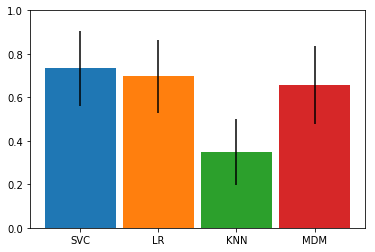

Best model: 
SVC
clf__C = 100
clf__gamma = 0.01
clf__kernel = rbf
metric = riemann
mean = 0.7040000000000001
std = 0.19303885619221844


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

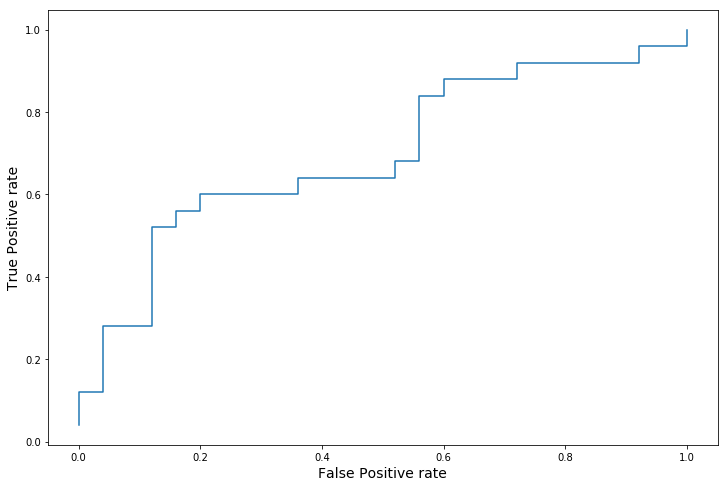

auc = 0.6960000000000001


,False Positive rate (fixed),False Negative rate
0,0.10,0.72
1,0.15,0.48
2,0.20,0.40
3,0.30,0.40


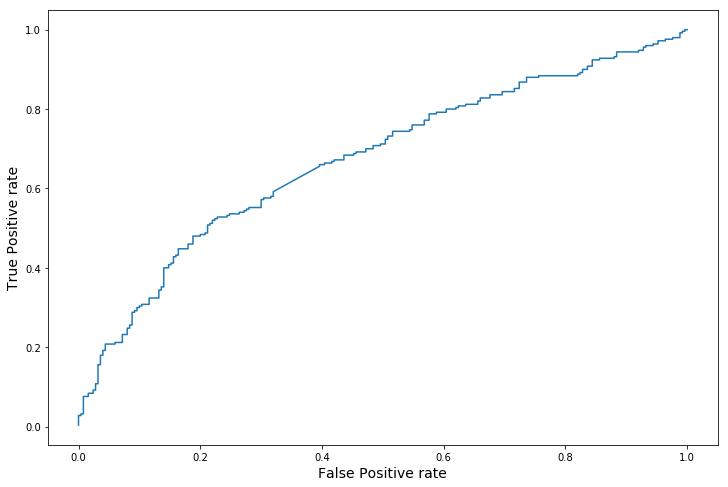

auc = 0.6729919999999999


In [7]:
n_splits = 5

y = labels[DE_D_idx]["target"]
data_DE_D = [data[i] for i in np.where(DE_D_idx == True)[0]]
pos_label = label_to_idx["DE"]
pipe = SPD_pipeline(tr, 0.1)


best_model_DE_D, grid_cv_svc_DE_D, grid_cv_lr_DE_D, grid_cv_mdm_DE_D, grid_cv_knn_DE_D = pipe.train_grid_cv(
    data_DE_D, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_DE_D)
scores_DE_D = cross_val_score(best_model_DE_D, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_DE_D.mean())
print("std =", scores_DE_D.std())


pipe.save_model(best_model_DE_D, "models/fmri_rim_DE_D.pkl")
probas_DE_D = pipe.repeated_cross_val_predict_proba(best_model_DE_D, data_DE_D, y, cv=cv, pos_label=pos_label, file = 'models/rim_DE_D_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DE_D, pos_label, DE_D_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DE_D, pos_label, DE_D_idx)
pipe.get_fpr_fnr(fpr, tpr)
                      
## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')